# Challenge: Make Your Network

[Boxing bout data](https://www.kaggle.com/slonsky/boxing-bouts) acquired from Kaggle.

In [1]:
import pandas as pd
import numpy as np
from numpy import nan
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import normalize

raw_data = pd.read_csv('./boxing_bouts.csv')

print('Data size:', raw_data.shape)
print('Result counts:\n', raw_data['result'].value_counts())

raw_data.head()

Data size: (387427, 26)
Result counts:
 win_A    321661
win_B     40994
draw      24772
Name: result, dtype: int64


,age_A,age_B,height_A,height_B,reach_A,reach_B,stance_A,stance_B,weight_A,weight_B,...,kos_A,kos_B,result,decision,judge1_A,judge1_B,judge2_A,judge2_B,judge3_A,judge3_B
0,35.0,27.0,179.0,175.0,178.0,179.0,orthodox,orthodox,160.0,160.0,...,33,34.0,draw,SD,110.0,118.0,115.0,113.0,114.0,114.0
1,26.0,31.0,175.0,185.0,179.0,185.0,orthodox,orthodox,164.0,164.0,...,34,32.0,win_A,UD,120.0,108.0,120.0,108.0,120.0,108.0
2,28.0,26.0,176.0,175.0,NaN,179.0,orthodox,orthodox,154.0,154.0,...,13,33.0,win_B,KO,NaN,NaN,NaN,NaN,NaN,NaN
3,25.0,29.0,175.0,174.0,179.0,180.0,orthodox,orthodox,155.0,155.0,...,32,19.0,win_A,KO,47.0,48.0,49.0,46.0,48.0,47.0
4,25.0,35.0,175.0,170.0,179.0,170.0,orthodox,orthodox,155.0,NaN,...,32,33.0,win_A,UD,118.0,110.0,119.0,109.0,117.0,111.0


In [2]:
df = raw_data.copy()

df['stance_A'] = df['stance_A'].apply(lambda x: 1 if x == 'orthodox' else 0)
df['stance_B'] = df['stance_B'].apply(lambda x: 1 if x == 'orthodox' else 0)
df['same_stance'] = df['stance_A'] == df['stance_B']

df['age_diff'] = df['age_A'] - df['age_B']
df['height_diff'] = df['height_A'] - df['height_B']
df['reach_diff'] = df['reach_A'] - df['reach_B']
df['weight_diff'] = df['weight_A'] - df['weight_B']

df['num_bouts_A'] = df['won_A'] + df['lost_A'] + df['drawn_A'] + df['kos_A']
df['num_bouts_B'] = df['won_B'] + df['lost_B'] + df['drawn_B'] + df['kos_B']
df['num_bouts_diff'] = df['num_bouts_A'] - df['num_bouts_B']

def get_record_percs_and_diffs():
    df['won_perc_A'] = (df['won_A'] + df['kos_A']) / df['num_bouts_A']
    df['won_perc_B'] = (df['won_B'] + df['kos_B']) / df['num_bouts_B']
    df['won_perc_diff'] = df['won_perc_A'] - df['won_perc_B']

    df['lost_perc_A'] = df['lost_A'] / df['num_bouts_A']
    df['lost_perc_B'] = df['lost_B'] / df['num_bouts_B']
    df['lost_perc_diff'] = df['lost_perc_A'] - df['lost_perc_B']

    df['drawn_perc_A'] = df['drawn_A'] / df['num_bouts_A']
    df['drawn_perc_B'] = df['drawn_B'] / df['num_bouts_B']
    df['drawn_perc_diff'] = df['drawn_perc_A'] - df['drawn_perc_B']

    df['kos_perc_A'] = df['kos_A'] / df['num_bouts_A']
    df['kos_perc_B'] = df['kos_B'] / df['num_bouts_B']
    df['kos_perc_diff'] = df['kos_perc_A'] - df['kos_perc_B']

get_record_percs_and_diffs()

def get_result(result):
    if result == 'draw':
        return 0
    elif result == 'win_A':
        return 1
    elif result == 'win_B':
        return 2

df['result'] = df['result'].apply(get_result)

# age shouldn't be more than 100, and age_diff shouldn't be more than 40
df = df[df['age_A'] < 100]
df = df[df['age_B'] < 100]
df = df[df['age_diff'] < 40]

df = df.drop(columns=['judge1_A', 'judge1_B', 'judge2_A', 'judge2_B', 'judge3_A', 'judge3_B'], axis=1)
df.head()

,age_A,age_B,height_A,height_B,reach_A,reach_B,stance_A,stance_B,weight_A,weight_B,...,won_perc_diff,lost_perc_A,lost_perc_B,lost_perc_diff,drawn_perc_A,drawn_perc_B,drawn_perc_diff,kos_perc_A,kos_perc_B,kos_perc_diff
0,35.0,27.0,179.0,175.0,178.0,179.0,1,1,160.0,160.0,...,0.023529,0.000000,0.011765,-0.011765,0.000000,0.011765,-0.011765,0.471429,0.400000,0.071429
1,26.0,31.0,175.0,185.0,179.0,185.0,1,1,164.0,164.0,...,0.011485,0.011905,0.023529,-0.011625,0.011905,0.011765,0.000140,0.404762,0.376471,0.028291
2,28.0,26.0,176.0,175.0,NaN,179.0,1,1,154.0,154.0,...,-0.002637,0.000000,0.012195,-0.012195,0.027027,0.012195,0.014832,0.351351,0.402439,-0.051088
3,25.0,29.0,175.0,174.0,179.0,180.0,1,1,155.0,155.0,...,0.031604,0.012500,0.056604,-0.044104,0.012500,0.000000,0.012500,0.400000,0.358491,0.041509
4,25.0,35.0,175.0,170.0,179.0,170.0,1,1,155.0,NaN,...,0.026632,0.012658,0.051948,-0.039290,0.012658,0.000000,0.012658,0.405063,0.428571,-0.023508


## Data Visualization, Cleaning, & Imputation

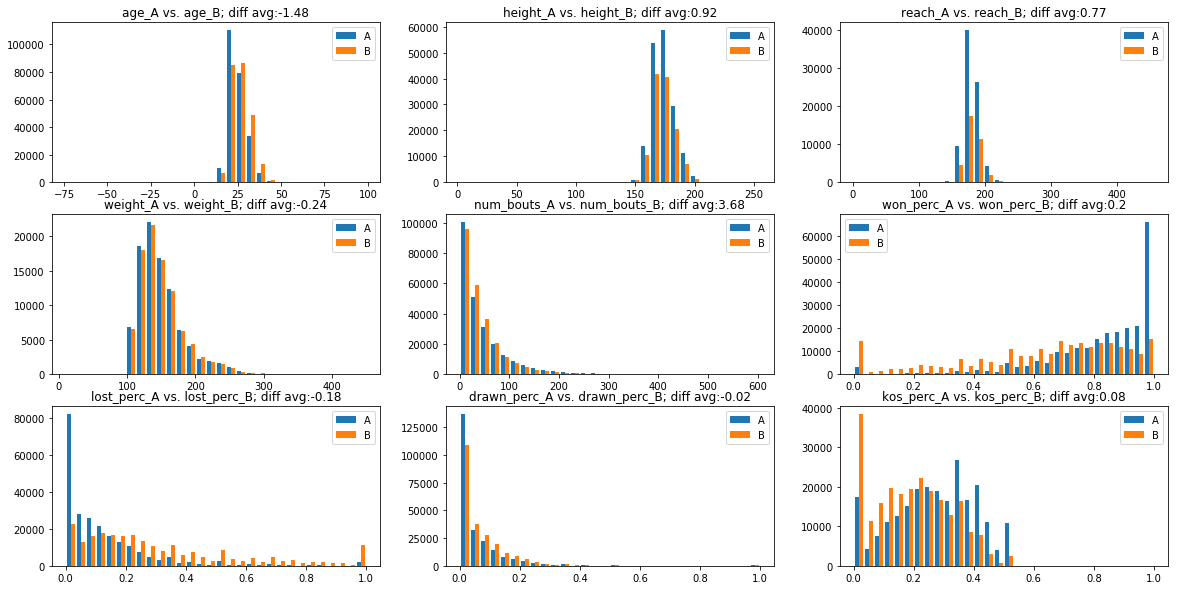

In [3]:
plt.figure(figsize=(20,10))
cols_to_graph = ['age', 'height', 'reach', 'weight', 'num_bouts', 'won_perc', 'lost_perc', 'drawn_perc', 'kos_perc']

for idx, col in enumerate(cols_to_graph):
    plt.subplot(3, 3, idx + 1)
    plt.hist([df[pd.notnull(df[col + '_A'])][col + '_A'], df[pd.notnull(df[col + '_B'])][col + '_B']], bins=30, label=['A', 'B'])
    plt.legend()
    plt.title(col + '_A vs. ' + col + '_B; diff avg:' + str(round(df[col + '_diff'].mean(), 2)))

plt.show()

In [4]:
def impute_values(col):
    avg_diff = df[col + '_diff'].mean()
    min_diff = df[col + '_diff'].min()
    max_diff = df[col + '_diff'].max()
    
    print('Avg', col, 'diff:', avg_diff)
    print('Min', col, 'diff:', min_diff)
    print('Max', col, 'diff:', max_diff)

    num_nans_before = df[col + '_A'].isnull().sum() + df[col + '_B'].isnull().sum()
    df[col + '_A'] = df[col + '_A'].fillna(df[col + '_B'].apply(lambda x: x + avg_diff))
    df[col + '_B'] = df[col + '_B'].fillna(df[col + '_A'].apply(lambda x: x - avg_diff))
    num_nans_after = df[col + '_A'].isnull().sum() + df[col + '_B'].isnull().sum()

    print(num_nans_before, 'NaNs before;', num_nans_after, 'NaNs after\n')

    df[col + '_diff'] = df[col + '_A'] - df[col + '_B']
    df[col + '_diff'].fillna(avg_diff, inplace=True)

In [5]:
impute_values('age')
impute_values('height')
impute_values('reach')
impute_values('weight')

Avg age diff: -1.4836327072755937
Min age diff: -93.0
Max age diff: 36.0
0 NaNs before; 0 NaNs after

Avg height diff: 0.916912114495086
Min height diff: -168.0
Max height diff: 161.0
190205 NaNs before; 94666 NaNs after

Avg reach diff: 0.7747408105560791
Min reach diff: -286.0
Max reach diff: 286.0
367777 NaNs before; 294652 NaNs after

Avg weight diff: -0.23916070785936694
Min weight diff: -207.0
Max weight diff: 217.0
296821 NaNs before; 238122 NaNs after



In [6]:
impute_values('num_bouts')
impute_values('drawn_perc')

# SHOULD NOT DO BELOW – distributions between A and B too divergent
# impute_values('won_perc')
# impute_values('lost_perc')
# impute_values('kos_perc')

# rerun everything that depends on num_bouts
get_record_percs_and_diffs()

Avg num_bouts diff: 3.6816705355628105
Min num_bouts diff: -585.0
Max num_bouts diff: 451.0
0 NaNs before; 0 NaNs after

Avg drawn_perc diff: -0.018082856476302228
Min drawn_perc diff: -1.0
Max drawn_perc diff: 1.0
18459 NaNs before; 5092 NaNs after



In [7]:
df = df.drop(columns=['age_A', 'age_B', 'height_A', 'height_B', 'reach_A', 'reach_B', 'weight_A', 'weight_B', 'decision'])

def mass_valid_check(row):
    if row['num_bouts_A'] == 0:
        row['won_perc_A'] = 0
        row['lost_perc_A'] = 0
        row['drawn_perc_A'] = 0
        row['kos_perc_A'] = 0
    
    if row['num_bouts_B'] == 0:
        row['won_perc_B'] = 0
        row['lost_perc_B'] = 0
        row['drawn_perc_B'] = 0
        row['kos_perc_B'] = 0
    
    if row['num_bouts_A'] == 0 or row['num_bouts_B'] == 0:
        row['won_perc_diff'] = row['won_perc_A'] - row['won_perc_B']
        row['lost_perc_diff'] = row['lost_perc_A'] - row['lost_perc_B']
        row['drawn_perc_diff'] = row['drawn_perc_A'] - row['drawn_perc_B']
        row['kos_perc_diff'] = row['kos_perc_A'] - row['kos_perc_B']
    return row

df = df.apply(mass_valid_check, axis=1)
df = df.dropna(subset=['kos_B']) # only 79 rows
print(df.isnull().sum(), df.shape)

df.head()

stance_A           0
stance_B           0
won_A              0
won_B              0
lost_A             0
lost_B             0
drawn_A            0
drawn_B            0
kos_A              0
kos_B              0
result             0
same_stance        0
age_diff           0
height_diff        0
reach_diff         0
weight_diff        0
num_bouts_A        0
num_bouts_B        0
num_bouts_diff     0
won_perc_A         0
won_perc_B         0
won_perc_diff      0
lost_perc_A        0
lost_perc_B        0
lost_perc_diff     0
drawn_perc_A       0
drawn_perc_B       0
drawn_perc_diff    0
kos_perc_A         0
kos_perc_B         0
kos_perc_diff      0
dtype: int64 (241671, 31)


,stance_A,stance_B,won_A,won_B,lost_A,lost_B,drawn_A,drawn_B,kos_A,kos_B,...,won_perc_diff,lost_perc_A,lost_perc_B,lost_perc_diff,drawn_perc_A,drawn_perc_B,drawn_perc_diff,kos_perc_A,kos_perc_B,kos_perc_diff
0,1,1,37,49,0,1,0,1,33,34.0,...,0.023529,0.000000,0.011765,-0.011765,0.000000,0.011765,-0.011765,0.471429,0.400000,0.071429
1,1,1,48,50,1,2,1,1,34,32.0,...,0.011485,0.011905,0.023529,-0.011625,0.011905,0.011765,0.000140,0.404762,0.376471,0.028291
2,1,1,23,47,0,1,1,1,13,33.0,...,-0.002637,0.000000,0.012195,-0.012195,0.027027,0.012195,0.014832,0.351351,0.402439,-0.051088
3,1,1,46,31,1,3,1,0,32,19.0,...,0.031604,0.012500,0.056604,-0.044104,0.012500,0.000000,0.012500,0.400000,0.358491,0.041509
4,1,1,45,40,1,4,1,0,32,33.0,...,0.026632,0.012658,0.051948,-0.039290,0.012658,0.000000,0.012658,0.405063,0.428571,-0.023508


In [8]:
# Normalize continuous variables
a_b_cols_to_norm = ['won', 'lost', 'drawn', 'kos', 'num_bouts', 'won_perc', 'lost_perc', 'drawn_perc', 'kos_perc']
temp_store = []
for col in a_b_cols_to_norm:
    temp_store.append(col + '_A')
    temp_store.append(col + '_B')
a_b_cols_to_norm = temp_store

diff_cols_to_norm = ['age', 'height', 'reach', 'weight', 'num_bouts', 'won_perc', 'lost_perc', 'drawn_perc', 'kos_perc']
diff_cols_to_norm = list(map(lambda x: x + '_diff', diff_cols_to_norm))

cols_to_norm = a_b_cols_to_norm + diff_cols_to_norm
df[cols_to_norm] = normalize(df[cols_to_norm])
df = pd.concat([df[cols_to_norm], df[df.columns.difference(cols_to_norm)]], axis=1)
df.head()

,won_A,won_B,lost_A,lost_B,drawn_A,drawn_B,kos_A,kos_B,num_bouts_A,num_bouts_B,...,weight_diff,num_bouts_diff,won_perc_diff,lost_perc_diff,drawn_perc_diff,kos_perc_diff,result,same_stance,stance_A,stance_B
0,0.272395,0.360740,0.000000,0.007362,0.000000,0.007362,0.242947,0.250309,0.515342,0.625773,...,0.000000,-0.110431,0.000173,-0.000087,-8.661216e-05,0.000526,0,True,1,1
1,0.327844,0.341504,0.006830,0.013660,0.006830,0.006830,0.232223,0.218563,0.573727,0.580557,...,0.000000,-0.006830,0.000078,-0.000079,9.565947e-07,0.000193,1,True,1,1
2,0.193525,0.395464,0.000000,0.008414,0.008414,0.008414,0.109384,0.277666,0.311323,0.689958,...,0.000000,-0.378636,-0.000022,-0.000103,1.247975e-04,-0.000430,2,True,1,1
3,0.382920,0.258054,0.008324,0.024973,0.008324,0.000000,0.266379,0.158162,0.665947,0.441190,...,0.000000,0.224757,0.000263,-0.000367,1.040542e-04,0.000346,1,True,1,1
4,0.334129,0.297004,0.007425,0.029700,0.007425,0.000000,0.237603,0.245028,0.586583,0.571733,...,-0.001776,0.014850,0.000198,-0.000292,9.398858e-05,-0.000175,1,True,1,1


In [9]:
# Every 3rd, just to cut down on data size / processing time
X = df.loc[::3, df.columns != 'result']
Y = df.loc[::3, 'result']

Y.value_counts()/len(Y)

1    0.812927
2    0.123316
0    0.063756
Name: result, dtype: float64

## Over-Sampling

In [10]:
sm = SMOTE(random_state=12, ratio = 1.0)
X_res, Y_res = sm.fit_sample(X, Y)
Counter(Y_res)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


Counter({0: 65487, 1: 65487, 2: 65487})

In [16]:
mlp = MLPClassifier(hidden_layer_sizes=(1000,), activation='logistic', learning_rate='adaptive')
mlp.fit(X_res, Y_res)
print('MLPClassifier score:', mlp.score(X, Y))

MLPClassifier score 0.5431557778963964


In [27]:
mlp_predict = mlp.predict(X)
mlp_crosstab = pd.crosstab(mlp_predict, Y)

print(mlp_crosstab, '\n')

for result in range(3):
    precision = mlp_crosstab.iloc[result, result] / (mlp_crosstab.iloc[result, :].sum())
    recall = mlp_crosstab.iloc[result, result] / (mlp_crosstab.iloc[:, result].sum())
    
    # QUESTION: HOW TO CALCULATE TYPE I AND TYPE II ERROR FOR PROBLEM WITH MORE THAN 2 OUTCOMES?
    print('For Result {}: precision - {}; recall - {}'.format(result, round(precision, 2), round(recall, 2)))
    print('   type i - {}; type ii - {}'.format(round(precision, 2), round(recall, 2)))

result     0      1     2
row_0                    
0       1989  10136  1940
1       1202  35594  1822
2       1945  19757  6172 

For Result 0: precision - 0.14; recall - 0.39
For Result 1: precision - 0.92; recall - 0.54
For Result 2: precision - 0.22; recall - 0.62


In [13]:
rfc = RandomForestClassifier(max_depth=2, random_state=0)
rfc.fit(X_res, Y_res)

print('Random Forest – feature importances')
for idx in range(len(X.columns)):
      print('*', X.columns[idx], '-', rfc.feature_importances_[idx])

rfc.score(X, Y)

Random Forest – feature importances
* won_A - 0.011365068645767385
* won_B - 0.0
* lost_A - 0.19100655334065184
* lost_B - 0.0
* drawn_A - 0.1265927411109807
* drawn_B - 0.0
* kos_A - 0.0
* kos_B - 0.0
* num_bouts_A - 0.0
* num_bouts_B - 0.0
* won_perc_A - 0.0
* won_perc_B - 0.004963242342801517
* lost_perc_A - 0.14869774763730295
* lost_perc_B - 0.05153060748031344
* drawn_perc_A - 0.15703729775225458
* drawn_perc_B - 0.04321769851832078
* kos_perc_A - 0.0
* kos_perc_B - 0.0
* age_diff - 0.04377299864227558
* height_diff - 0.0
* reach_diff - 0.0
* weight_diff - 0.0
* num_bouts_diff - 0.0
* won_perc_diff - 0.0957676009352966
* lost_perc_diff - 0.11872742703338897
* drawn_perc_diff - 0.007321016560645724
* kos_perc_diff - 0.0
* same_stance - 0.0
* stance_A - 0.0
* stance_B - 0.0


0.5454026341596634

In [28]:
rfc_predict = rfc.predict(X)
rfc_crosstab = pd.crosstab(rfc_predict, Y)

print(rfc_crosstab, '\n')

for result in range(3):
    precision = rfc_crosstab.iloc[result, result] / (rfc_crosstab.iloc[result, :].sum())
    recall = rfc_crosstab.iloc[result, result] / (rfc_crosstab.iloc[:, result].sum())
    
    # QUESTION: HOW TO CALCULATE TYPE I AND TYPE II ERROR FOR PROBLEM WITH MORE THAN 2 OUTCOMES?
    print('For Result {}: precision - {}; recall - {}'.format(result, round(precision, 2), round(recall, 2)))

result     0      1     2
row_0                    
0       1639  15982  1741
1       1668  36914  2810
2       1829  12591  5383 

For Result 0: precision - 0.08; recall - 0.32
For Result 1: precision - 0.89; recall - 0.56
For Result 2: precision - 0.27; recall - 0.54
